In [140]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm

SIM_SIZE = 100000
NUM_YEARS = 15

drill_costs = pd.read_excel("Analysis_Data.xlsx", header=2, sheet_name="Drilling Cost")

drill_costs.head(10)

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
0,1960-06-30,52.2,102.7,44.0,.,.,.
1,1961-06-30,51.3,94.7,45.2,-0.017241,-0.077897,0.027273
2,1962-06-30,54.2,97.1,50.8,0.05653,0.025343,0.123894
3,1963-06-30,51.8,92.4,48.2,-0.04428,-0.048404,-0.051181
4,1964-06-30,50.6,104.8,48.5,-0.023166,0.134199,0.006224
5,1965-06-30,56.6,101.9,53.1,0.118577,-0.027672,0.094845
6,1966-06-30,62.2,133.8,56.9,0.09894,0.313052,0.071563
7,1967-06-30,66.6,141.0,61.5,0.07074,0.053812,0.080844
8,1968-06-30,79.1,148.5,66.2,0.187688,0.053191,0.076423
9,1969-06-30,86.5,154.3,70.2,0.093552,0.039057,0.060423


# Phase 1: Drilling Costs

In [141]:
drill_costs = drill_costs[
    (drill_costs["Date"].dt.year >= 1991) & (drill_costs["Date"].dt.year <= 2006)
]
drill_costs

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
31,1991-06-30,346.9,506.6,441.2,0.077999,0.074899,0.200544
32,1992-06-30,362.3,426.1,357.6,0.044393,-0.158902,-0.189483
33,1993-06-30,356.6,521.2,387.7,-0.015733,0.223187,0.084172
34,1994-06-30,409.5,535.1,491.5,0.148345,0.026669,0.267733
35,1995-06-30,415.8,629.7,481.2,0.015385,0.176789,-0.020956
36,1996-06-30,341.0,616.0,541.0,-0.179894,-0.021756,0.124273
37,1997-06-30,445.6,728.6,655.6,0.306745,0.182792,0.21183
38,1998-06-30,566.0,815.6,973.2,0.270197,0.119407,0.484442
39,1999-06-30,783.0,798.4,1115.5,0.383392,-0.021089,0.146219
40,2000-06-30,593.4,756.9,1075.4,-0.242146,-0.051979,-0.035948


In [142]:
returns = drill_costs.filter(regex="^Arithmetic Return").to_numpy().flatten()
drill_costs["avg_cost"] = drill_costs.filter(regex="^U\.S\.").mean(axis=1)
returns, drill_costs["avg_cost"]

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7s/plv7qn294jg_4c9nxj_69_380000gn/T/ipykernel_16942/3666268403.py:2: SyntaxWarning: invalid escape sequence '\.'
  drill_costs["avg_cost"] = drill_costs.filter(regex="^U\.S\.").mean(axis=1)


(array([0.07799875699192034, 0.0748992149374072, 0.2005442176870748,
        0.04439319688671097, -0.1589024871693644, -0.18948322756119668,
        -0.015732818106541507, 0.22318704529453184, 0.08417225950782987,
        0.14834548513740878, 0.026669224865694504, 0.26773278307970083,
        0.015384615384615413, 0.17678938516165207, -0.02095625635808751,
        -0.1798941798941799, -0.02175639193266642, 0.12427265170407317,
        0.3067448680351907, 0.18279220779220784, 0.21182994454713497,
        0.2701974865350089, 0.11940708207521274, 0.4844417327638804,
        0.3833922261484099, -0.021088769004413983, 0.14621866009042328,
        -0.24214559386973183, -0.05197895791583167, -0.03594800537875384,
        0.22868217054263573, 0.1844365173734972, 0.5067881718430352,
        0.21080784528871202, 0.10641383156720577, 0.03270797333991607,
        0.17501132759401905, 0.11503175723359212, 0.2340743396677422,
        0.38995469006073463, 0.5518987341772152, -0.042516100915209895,
  

In [143]:
rng = np.random.default_rng(1234)
kernel = gaussian_kde(returns)

initial_cost = drill_costs["avg_cost"].iloc[-1]

mean_return = returns.mean()
std_return = returns.std()

years_1 = 2012 - 2006
years_2 = 2015 - 2012
years_3 = 2024 - 2015

kernel.factor

0.4610539557408639

In [144]:
norm_data = []

for i in range(SIM_SIZE):
    normal_return = rng.normal(mean_return, std_return, years_1)

    phase_2 = rng.triangular(left=-0.22, mode=-0.0917, right=-0.07, size=years_2)
    phase_3 = rng.triangular(left=0.02, mode=0.05, right=0.06, size=years_3)

    normal_phases = np.concatenate((normal_return, phase_2, phase_3))

    normal_future_vals = initial_cost * np.cumprod(1 + normal_phases)
    norm_data.append(normal_future_vals[-1])

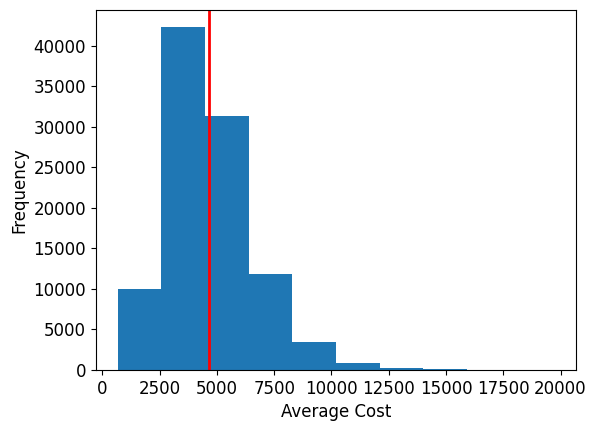

In [145]:
plt.rcParams.update({"font.size": 12})
plt.hist(norm_data)
plt.axvline(x=np.mean(norm_data), color="r", linestyle="-", linewidth=2)
plt.xlabel("Average Cost")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()

# Year 0 Expenses

In [146]:
def calculate_initial_expenses(is_dry: bool) -> np.ndarray:
    acres = rng.normal(600, 50)
    acres_cost = acres * 960
    seismic_sections = rng.normal(3, 0.35)
    seismic_sections_cost = seismic_sections * 43000
    completion_cost = 0

    if not is_dry:
        completion_cost = rng.normal(390000, 50000)

    prof_overhead = rng.triangular(left=172000, mode=215000, right=279500)
    return acres_cost + seismic_sections_cost + prof_overhead + completion_cost


dry_well = []
for _ in range(SIM_SIZE):
    initial_cost = calculate_initial_expenses(is_dry=True)
    dry_well.append(initial_cost)

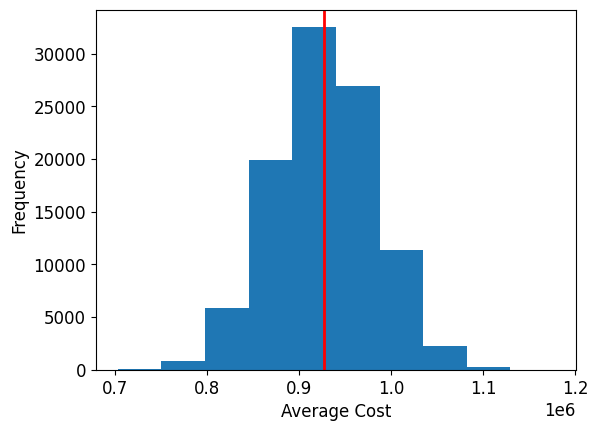

In [147]:
plt.rcParams.update({"font.size": 12})
plt.hist(dry_well)
plt.axvline(x=np.mean(dry_well), color="r", linestyle="-", linewidth=2)
plt.xlabel("Average Cost")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()

# Production Risk

In [148]:
import scipy as sp


def standardize(x):
    x_std = (x - np.mean(x)) / np.std(x)
    return x_std


def destandardize(x_std, x):
    x_old = (x_std * np.std(x)) + np.mean(x)
    return x_old


R = np.array([[1, 0.64], [0.64, 1]])
U = sp.linalg.cholesky(R, lower=False)

init_production = rng.lognormal(6, 0.28, size=SIM_SIZE)
decline_rate = rng.uniform(0.15, 0.32, size=SIM_SIZE)

combined = np.array([standardize(init_production), standardize(decline_rate)])
combined_u = U @ combined
final_combined = np.array(
    [
        destandardize(combined_u[0], init_production),
        destandardize(combined_u[1], decline_rate),
    ]
)


def calculate_annual_production(init_p: float, decline_r: float) -> float:
    rate_year_end = init_p * np.cumprod(1 - np.repeat(decline_r, NUM_YEARS))
    rate_year_begin = np.concatenate(([init_p], rate_year_end[:-1]))
    oil_volume_year = 365 * (rate_year_begin + rate_year_end) / 2
    return oil_volume_year


calculate_annual_production(init_production[0], decline_rate[0])

array([111785.0272132 ,  77091.69791379,  53165.70595717,  36665.32670075,
        25285.96503836,  17438.27439857,  12026.17394822,   8293.75983697,
         5719.72869588,   3944.56760234,   2720.34119042,   1876.06271164,
         1293.81244911,    892.26796263,    615.34584683])

# Revenue Risk

In [149]:
price_projections = pd.read_excel("Analysis_Data.xlsx", header=2, sheet_name="Price Projections")
price_projections

,Year,High Oil Price,Low Oil Price,AEO2023 Reference
0,2025,167.871078,46.165466,85.233162
1,2026,166.263016,45.745247,85.255096
2,2027,167.971329,46.518333,85.532898
3,2028,166.407440,47.305279,86.264732
4,2029,166.329147,47.445293,86.738144
5,2030,167.323944,47.981407,87.188271
6,2031,169.405746,48.612011,87.748749
7,2032,168.357391,49.241779,88.512123
8,2033,170.008057,48.129913,88.937447
9,2034,172.798264,47.247337,89.608727


In [150]:
def calculate_oil_price():
    return np.array([rng.triangular(left=price_projections.loc[i, "Low Oil Price"], mode=price_projections.loc[i, "AEO2023 Reference"], right=price_projections.loc[i, "High Oil Price"]) for i in range(NUM_YEARS)])

calculate_oil_price()

array([ 87.332857  , 102.46410958, 114.99053681, 145.63400712,
        65.89497339,  72.97680794,  86.65976389,  91.36617681,
       116.39968871, 131.6952312 , 107.96896228, 151.196627  ,
        59.393384  , 102.88106238,  89.30385348])

In [151]:
def calculate_operating_expenses(annual_production: np.ndarray, annual_revenue: np.ndarray) -> np.ndarray:
    operating_costs = rng.normal(2.25, 0.30, size=NUM_YEARS)
    annual_operating_expenses = operating_costs * annual_production + 0.046 * annual_revenue
    return annual_operating_expenses

# Main Simulation

In [152]:
net_present_values = []
for i in tqdm(range(SIM_SIZE), desc="Calculating NPV"):
    initial_cost = norm_data[i] + calculate_initial_expenses(is_dry=False)
    annual_prod = calculate_annual_production(init_production[i], decline_rate[i])
    oil_prices = calculate_oil_price() 
    net_revenue_interest = rng.normal(0.75, 0.02, size=NUM_YEARS)
    annual_revenue = annual_prod * oil_prices * net_revenue_interest
    annual_operating_expenses = calculate_operating_expenses(annual_prod, annual_revenue)
    final_net_revenue = annual_revenue - annual_operating_expenses

    net_present_value = -1 * initial_cost + npf.npv(rate=0.1, values=final_net_revenue)
    net_present_values.append(net_present_value)

Calculating NPV: 100%|██████████| 100000/100000 [00:16<00:00, 5889.16it/s]


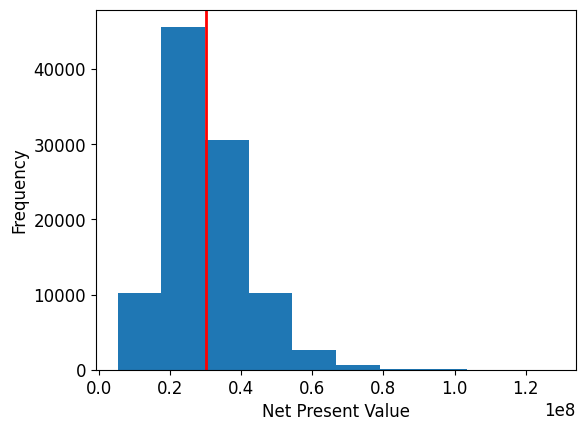

In [153]:
plt.rcParams.update({"font.size": 12})
plt.hist(net_present_values)
plt.axvline(x=np.mean(net_present_values), color="r", linestyle="-", linewidth=2)
plt.xlabel("Net Present Value")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()